<a href="https://mng.bz/8wdg" target="_blank">
    <img src="../../Assets/Images/NewMEAPHeader.png" alt="New MEAP" style="width: 100%;" />
</a>


# Chapter 03 - Indexing Pipeline: Creating a Knowledge Base for RAG-based Applications

### Welcome to chapter 3 of A Simple Introduction to Retrieval Augmented Generation. This is the first chapter of the book where we use code examples in python.

In this chapter, we introduce the concepts behind the indexing pipeline that facilitates building a knowledge base for RAG enabled applications

The example that we have been following is to ask the question - __Who won the 2023 Cricket World Cup?__ to a Large Language Model. We are fetching context from a __Wikipedia Article__ - https://en.wikipedia.org/wiki/2023_Cricket_World_Cup

We first did this manually with ChatGPT. Now, we will do this programatically. We will be using a very popular orchestration framework in python called __LangChain__ - https://www.langchain.com/

<img src="../../Assets/Images/3.1.png">

## Installing Dependencies

All the necessary libraries for running this notebook along with their versions can be found in __requirements.txt__ file in the root directory of this repository

You should go to the root directory and run the following command to install the libraries

```
pip install -r requirements.txt
```

This is the recommended method of installing the dependencies

___
Alternatively, you can run the command from this notebook too. The relative path may vary

In [1]:
%pip install -r ../../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


## 1. Loading Data

The first step towards building a knowledge base (or non-parametric memory) of a RAG-enabled system is to source data from its original location. This data may be in the form of word documents, pdf files, csv, HTML etc. Further, the data may be stored in file, block or object stores, in data lakes, data warehouses or even in third party sources that can be accessed via the open internet. This process of sourcing data from its original location is called __Data Loading__. 

Data Loading includes the following four steps:
- __Connection__ to the source of the data
- __Extraction and Parsing of text__ from the source format
- Reviewing and updating __metadata__ information
- Cleaning or __transforming__ the data


<img src="../../Assets/Images/3.2.png" width=400>

We will now use LangChain to __connect to Wikipedia__ and __extract data__ from the page about the 2023 Cricket World Cup. For this we will use the __AsyncHtmlLoader__ function from the document_loaders library in the langchain-community package.

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

from langchain_community.document_loaders import AsyncHtmlLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
#This is the url of the wikipedia page on the 2023 Cricket World Cup
url="https://en.wikipedia.org/wiki/2023_Cricket_World_Cup"

#Instantiating the AsyncHtmlLoader
loader = AsyncHtmlLoader (url)

#Loading the extracted information
data = loader.load()


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  4.16it/s]


To verify the extracted text and the metadata, let us print a few tokens

In [4]:
print(f"First 100 characters of extracted content -\n\n{data[0].page_content[:100]}\n------------------\n")

print(f"Metadata information - \n\n{data[0].metadata}\n------------------\n")

First 100 characters of extracted content -

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-la
------------------

Metadata information - 

{'source': 'https://en.wikipedia.org/wiki/2023_Cricket_World_Cup', 'title': '2023 Cricket World Cup - Wikipedia', 'language': 'en'}
------------------



We can see that some __content has been extracted__. Also, some __metadata__ information is present.

The content is in __HTML format__ which does not convey a lot of factual information. We will now transform this data into a readable format using __Html2TextTransformer__ class.

In [5]:
from langchain_community.document_transformers import Html2TextTransformer

#Instantiate the Html2TextTransformer function
html2text = Html2TextTransformer()


#Call transform_documents
data_transformed = html2text.transform_documents(data)

Let us review the extracted content, now transformed by the Html2TextTransformer

In [6]:
print(f"First 100 characters of extracted content -\n\n{data_transformed[0].page_content[:100]}\n---------------------\n")

First 100 characters of extracted content -

Jump to content

Main menu

Main menu

move to sidebar hide

Navigation

  * Main page
  * Contents

---------------------



Now, we see that we have text in a __readable english__ language!

Next, we will move to the next step of __data splitting__ or __chunking__

## 2. Data Splitting (Chunking)

Breaking down long pieces of text into manageable sizes is called __Data Splitting__ or __Chunking__. This is done for various reasons like Context Window Limitations, Search Complexity, Lost in the middle kind of issues.

Chunking is conducted in three steps - 
1.	Divide the longer text into compact, meaningful units like sentences or paragraphs.
2.	Merge the smaller units into larger chunks until a specific size is achieved. Once the size is achieved, this chunk is treated as an independent segment of text.
3.	When a new chunk is being created include a part of the previous chunk at the start of the new chunk. This overlap is necessary to maintain contextual continuity. 


<img src="../../Assets/Images/3.3.png" width=600>

We can now look at different chunking methods

#### Fixed Size Chunking

A very common approach is to pre-determine the size of the chunk and the amount of overlap between the chunks. 

In [7]:
#import libraries
from langchain_text_splitters import CharacterTextSplitter
#Set the CharacterTextSplitter parameters
text_splitter = CharacterTextSplitter(
separator="\n", #The character that should be used to split 
chunk_size=1000, #Number of characters in each chunk 
chunk_overlap=200, #Number of overlapping characters between chunks
)
#Create Chunks
chunks=text_splitter.create_documents([data_transformed[0].page_content])

#Show the number of chunks created
print(f"The number of chunks created : {len(chunks)}")

The number of chunks created : 65


In all, this method created 65 chunks. But what about the overlap. Let us check two chunks at random, say, chunk 4 and chunk 5. We will compare the last 200 characters of chunk 4 with the first 200 characters of chunk 5.

In [8]:
chunks[4].page_content[-200:]

'dia was announced by the ICC as hosts of the 2023\nCricket World Cup; while India had served as a co-host during three previous\ntournaments (most recently in 2011, which it co-hosted with Sri Lanka and'

In [9]:
chunks[5].page_content[:200]

'Cricket World Cup; while India had served as a co-host during three previous\ntournaments (most recently in 2011, which it co-hosted with Sri Lanka and\nBangladesh), it would mark the first Cricket Worl'

#### Specialized Chunking

The aim of chunking is to keep meaningful data together. If we are dealing with data in form of HTML, Markdown, JSON or even computer code, it makes more sense to split the data based on the structure rather than a fixed size. 

In [10]:
# Import the HTMLHeaderTextSplitter library
from langchain_text_splitters import HTMLHeaderTextSplitter
# Set url as the Wikipedia page link
url="https://en.wikipedia.org/wiki/2023_Cricket_World_Cup"
# Specify the header tags on which splits should be made
headers_to_split_on=[ ("h1", "Header 1"), ("h2", "Header 2"), ("h3", "Header 3"), ("h4", "Header 4")
]
# Create the HTMLHeaderTextSplitter function
html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
# Create splits in text obtained from the url
html_header_splits = html_splitter.split_text_from_url(url)

In [11]:
len(html_header_splits)

3

In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter( chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(html_header_splits)

In [13]:
len(chunks)

57

<img src="../../Assets/Images/3.4.png">

## Data Conversion (Embeddings)

Computers, at the very core, do mathematical calculations. Mathematical calculations are done on numbers. Therefore, for a computer to process any kind of non-numeric data like text or image, it must be first converted into a numerical form. 

Embeddings is a design pattern that is extremely helpful in the fields of data science, machine learning and artificial intelligence. Embeddings are vector representations of data. As a general definition, embeddings are data that has been transformed into n-dimensional matrices. A word embedding is a vector representation of words. 

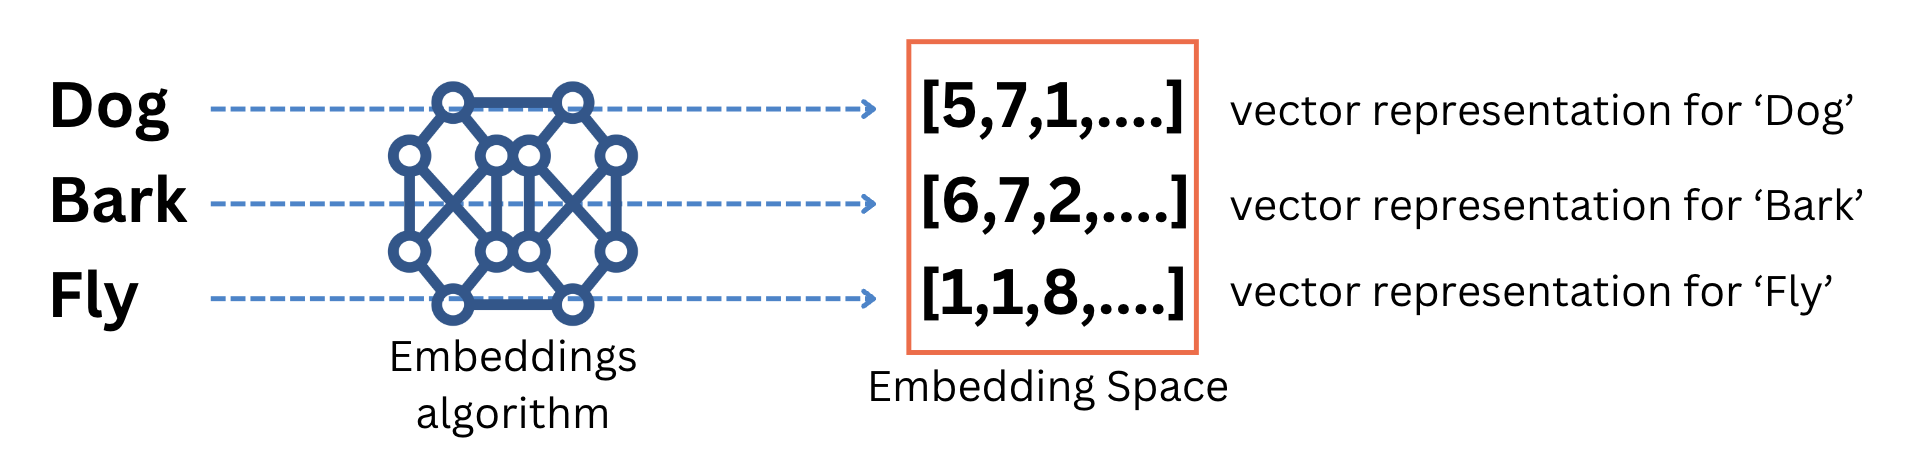

#### Open Source Embeddings from HuggingFace

In [14]:
# Import HuggingFaceEmbeddings from embeddings library
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

# Instantiate the embeddings model. The embeddings model_name can be changed as desired
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-l6-v2")

# Create embeddings for all chunk
chunk_embedding = embeddings.embed_documents([chunk.page_content for chunk in chunks])

#Check the length(dimension) of the embedding
len(chunk_embedding[0])

384

#### OpenAI Embeddings text-embedding-3-large

Embeddings Models by OpenAI


OpenAI, the company behind ChatGPT and GPT series of Large Language Models also provide three Embeddings Models. 

1.	text-embedding-ada-002 was released in December 2022. It has a dimension of 1536 meaning that it converts text into a vector of 1536 dimensions.
2.	text-embedding-3-small is the latest small embedding model of 1536 dimensions released in January 2024. The flexibility it provides over ada-002 model is that users can adjust the size of the dimensions according to their needs.
3.	text-embedding-3-large is a large embedding model of 3072 dimensions released together with the text-embedding-3-small model. It is the best performing model released by OpenAI yet.


OpenAI models are closed source and can be accessed using the OpenAI API and are priced based on the number of input tokens for which embeddings are desired. 


Note: You will need an __OpenAI API Key__ which can be obtained from [OpenAI](https://platform.openai.com/api-keys)

To initialize the __OpenAI client__, we need to pass the api key. There are many ways of doing it. 

####  [Option 1] Creating a .env file for storing the API key and using it # Recommended

Install the __dotenv__ library

_The dotenv library is a popular tool used in various programming languages, including Python and Node.js, to manage environment variables in development and deployment environments. It allows developers to load environment variables from a .env file into their application's environment._

- Create a file named .env in the root directory of their project.
- Inside the .env file, then define environment variables in the format VARIABLE_NAME=value. 

e.g.

OPENAI_API_KEY=YOUR API KEY

In [15]:
from dotenv import load_dotenv
import os

if load_dotenv():
    print("Success: .env file found with some environment variables")
else:
    print("Caution: No environment variables found. Please create .env file in the root directory or add environment variables in the .env file")

Success: .env file found with some environment variables


#### [Option 2] Alternatively, you can set the API key in code. 
However, this is not recommended since it can leave your key exposed for potential misuse. Uncomment the cell below to use this method.

In [21]:
# import os
# os.environ["OPENAI_API_KEY"] = "sk-proj-******" #Imp : Replace with an OpenAI API Key

We can also test if the key is valid or not

In [17]:
api_key=os.environ["OPENAI_API_KEY"]

from openai import OpenAI

client = OpenAI()


if api_key:
    try:
        client.models.list()
        print("OPENAI_API_KEY is set and is valid")
    except openai.APIError as e:
        print(f"OpenAI API returned an API Error: {e}")
        pass
    except openai.APIConnectionError as e:
        print(f"Failed to connect to OpenAI API: {e}")
        pass
    except openai.RateLimitError as e:
        print(f"OpenAI API request exceeded rate limit: {e}")
        pass

else:
    print("Please set you OpenAI API key as an environment variable OPENAI_API_KEY")



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


OPENAI_API_KEY is set and is valid


In [56]:
# Import OpenAIEmbeddings from the library
from langchain_openai import OpenAIEmbeddings
import os
os.environ["TOKENIZERS_PARALLELISM"]="false"
# Instantiate the embeddings object
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
# Create embeddings for all chunks
chunk_embedding = embeddings.embed_documents([chunk.page_content for chunk in chunks])
#Check the length(dimension) of the embedding
len(chunk_embedding[0])

3072

## Storage (Vector Databases)

The data has been loaded, split, and converted into embeddings. For us to use this information repeatedly, we need to store it in memory so that it can be accessed on demand. Vector Databases are built to handle high dimensional vectors. These databases specialize in indexing and storing vector embeddings for fast semantic search and retrieval. 

#### Facebook AI Similarity Search (FAISS)

In [18]:
# Import FAISS class from vectorstore library
from langchain_community.vectorstores import FAISS
# Import OpenAIEmbeddings from the library
from langchain_openai import OpenAIEmbeddings
# Set the OPENAI_API_KEY as the environment variable
import os
# Chunks from previous section
chunks=chunks
# Instantiate the embeddings object
embeddings=OpenAIEmbeddings(model="text-embedding-3-large")
# Create the database
db=FAISS.from_documents(chunks,embeddings)
# Check the number of chunks that have been indexed
db.index.ntotal

57

This created index can be stored and used later for generation.

In [19]:
db.save_local("../../Assets/Data")

## Search and Retrieval Example

As a glimpse of what happens next, this Vector Index can be used to retrieve documents that are most relevant to the query.

In [20]:
# Original Question
query = "Who won the 2023 Cricket World Cup?"
# Ranking the chunks in descending order of similarity
docs = db.similarity_search(query)
# Printing the top ranked chunk
print(docs[0].page_content)

2023 ICC Men's Cricket World CupDates5 October – 19 November 2023Administrator(s)International Cricket CouncilCricket formatOne Day International (ODI)Tournament format(s)Round-robin and knockoutHost(s) IndiaChampions Australia (6th title)Runners-up IndiaParticipants10Matches48Attendance1,250,307 (26,048 per match)Player of the series Virat KohliMost runs Virat Kohli (765)Most wickets Mohammed Shami (24)Official websitecricketworldcup.com Highlighted are the countries that participated in the 2023 Cricket World Cup. Means of qualification Date Venue Berths Qualified Host nation — — 1  India ICC Super League 30 July 2020 – 14 May 2023 Various 7 Qualifier 18 June 2023 – 9 July 2023 Zimbabwe 2 Total 10 Location Stadium Capacity[19] No. of matches Ahmedabad Narendra Modi Stadium 132,000 5 Bangalore M. Chinnaswamy Stadium 33,800 5 Chennai M. A. Chidambaram Stadium 38,200 5 Delhi Arun Jaitley Stadium 35,200 5 Dharamshala HPCA Stadium 21,200 5 Hyderabad Rajiv Gandhi International Cricket


---

This brings us at the end of Chapter 3. The four steps of loading, chunking, embedding and storing complete the indexing pipeline. Indexing pipeline is an __offline process__. The Vector Index needs to be created once and then updated at a periodic frequency.

In Chapter 4, we will use this created index or knowledge base to handle real-time generations.

---

<img src="../../Assets/Images/profile_s.png" width=100> 

Hi! I'm Abhinav! I am an entrepreneur and Vice President of Artificial Intelligence at Yarnit. I have spent over 15 years consulting and leadership roles in data science, machine learning and AI. My current focus is in the applied Generative AI domain focussing on solving enterprise needs through contextual intelligence. I'm passionate about AI advancements constantly exploring emerging technologies to push the boundaries and create positive impacts in the world. Let’s build the future, together!

[If you haven't already, please subscribe to the MEAP of A Simple Guide to Retrieval Augmented Generation here](https://mng.bz/8wdg)

<a href="https://mng.bz/8wdg" target="_blank">
    <img src="../../Assets/Images/NewMEAPFooter.png" alt="New MEAP" style="width: 100%;" />
</a>

#### If you'd like to chat, I'd be very happy to connect

[![GitHub followers](https://img.shields.io/badge/Github-000000?style=for-the-badge&logo=github&logoColor=black&color=orange)](https://github.com/abhinav-kimothi)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-000000?style=for-the-badge&logo=linkedin&logoColor=orange&color=black)](https://www.linkedin.com/comm/mynetwork/discovery-see-all?usecase=PEOPLE_FOLLOWS&followMember=abhinav-kimothi)
[![Medium](https://img.shields.io/badge/Medium-000000?style=for-the-badge&logo=medium&logoColor=black&color=orange)](https://medium.com/@abhinavkimothi)
[![Insta](https://img.shields.io/badge/Instagram-000000?style=for-the-badge&logo=instagram&logoColor=orange&color=black)](https://www.instagram.com/akaiworks/)
[![Mail](https://img.shields.io/badge/email-000000?style=for-the-badge&logo=gmail&logoColor=black&color=orange)](mailto:abhinav.kimothi.ds@gmail.com)
[![X](https://img.shields.io/badge/Follow-000000?style=for-the-badge&logo=X&logoColor=orange&color=black)](https://twitter.com/abhinav_kimothi)
[![Linktree](https://img.shields.io/badge/Linktree-000000?style=for-the-badge&logo=linktree&logoColor=black&color=orange)](https://linktr.ee/abhinavkimothi)
[![Gumroad](https://img.shields.io/badge/Gumroad-000000?style=for-the-badge&logo=gumroad&logoColor=orange&color=black)](https://abhinavkimothi.gumroad.com/)